# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [93]:
# If this cell does not work try running `pip install nbformat`

import io
# from IPython 
import nbformat

nb = nbformat.read("Lab1.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 374


## Group Number :

## Student 1 
### Name : Amar Mesic
### ID : 5106117

## Student 2
### Name : Athanasios Georgoutsos
### ID : 6015883

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
# Libraries used in this lab assignment

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

# NOTE: The following code defines the paths of the data files
# Modify with your own paths OR
# Create a directory with the name "cda-lab-1-credit-card-fraud" in the same directory 
# as this .ipynb file and place the data files in it

train_path = 'cda-lab-1-credit-card-fraud/train_data.csv'
test_path = 'cda-lab-1-credit-card-fraud/test_data.csv'

In [14]:
df = pd.read_csv(train_path)

## 1. Visualization task – 1 A4

### 1a. Plot visulations 

In [79]:
# Train data loading and preprocessing
df1 = pd.read_csv(train_path)

#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
enc = LabelEncoder()
enc.fit(unique_codes)
df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)
df['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)


enc1 = LabelEncoder()
enc1.fit(df1['txvariantcode'])
df1['txvariantcode'] = enc1.transform(df1.txvariantcode)

enc2 = LabelEncoder()
enc2.fit(df1['currencycode'])
df1['currencycode'] = enc2.transform(df1.currencycode)

enc3 = LabelEncoder()
enc3.fit(df1['shopperinteraction'])
df1['shopperinteraction'] = enc3.transform(df1.shopperinteraction)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

enc4 = LabelEncoder()
enc4.fit(df1['accountcode'])
df1['accountcode'] = enc4.transform(df1.accountcode)

enc5 = LabelEncoder()
enc5.fit(df1['cardverificationcodesupplied'])
df1['cardverificationcodesupplied'] = enc5.transform(df1.cardverificationcodesupplied)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

enc6 = LabelEncoder()
enc6.fit(df1['mail_id'])
df1['mail_id'] = enc6.transform(df1.mail_id)

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1


X = df1[['issuercountrycode','txvariantcode','bin','amount','currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','accountcode','mail_id','ip_id','card_id','amount_eur','countries_equal']]

/var/folders/gn/8cmn0qdj1mx7g0mxnt5q722h0000gp/T/ipykernel_95714/2997022063.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GB' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
/var/folders/gn/8cmn0qdj1mx7g0mxnt5q722h0000gp/T/ipykernel_95714/2997022063.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0


In [80]:
print('df columns: ', df1.columns)
print('x columns: ', X.columns)

fraudulent_df = df.query('label==1')
normal_df = df[df['label'] == 0]

print('Fraudulent transactions: ', fraudulent_df.shape[0])
print('Normal transactions: ', normal_df.shape[0])
print('all transactions: ', df1.shape[0])

df columns:  Index(['Id', 'issuercountrycode', 'txvariantcode', 'bin', 'amount',
       'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
       'mail_id', 'ip_id', 'card_id', 'label', 'amount_eur', 'accountcode_cc',
       'countries_equal'],
      dtype='object')
x columns:  Index(['issuercountrycode', 'txvariantcode', 'bin', 'amount', 'currencycode',
       'shoppercountrycode', 'shopperinteraction',
       'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
       'mail_id', 'ip_id', 'card_id', 'amount_eur', 'countries_equal'],
      dtype='object')
Fraudulent transactions:  276
Normal transactions:  189352
all transactions:  189628


In [81]:
df1.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,accountcode_cc,countries_equal
0,1,49,2,546097.0,4500.0,1,49,1,1,1,3,17805,12538,105460,0,52.175123,GB,1
1,2,49,3,557349.0,3395.0,1,49,1,1,1,3,115620,107432,29882,0,39.363232,GB,1
2,3,49,2,542011.0,3895.0,1,49,1,1,1,3,84651,87293,123743,0,45.160467,GB,1
3,4,49,8,465943.0,15345.0,1,49,0,0,0,3,99845,147089,14712,0,177.917169,GB,1
4,6,49,8,475127.0,5095.0,1,49,1,1,1,3,122624,56390,75841,0,59.073834,GB,1


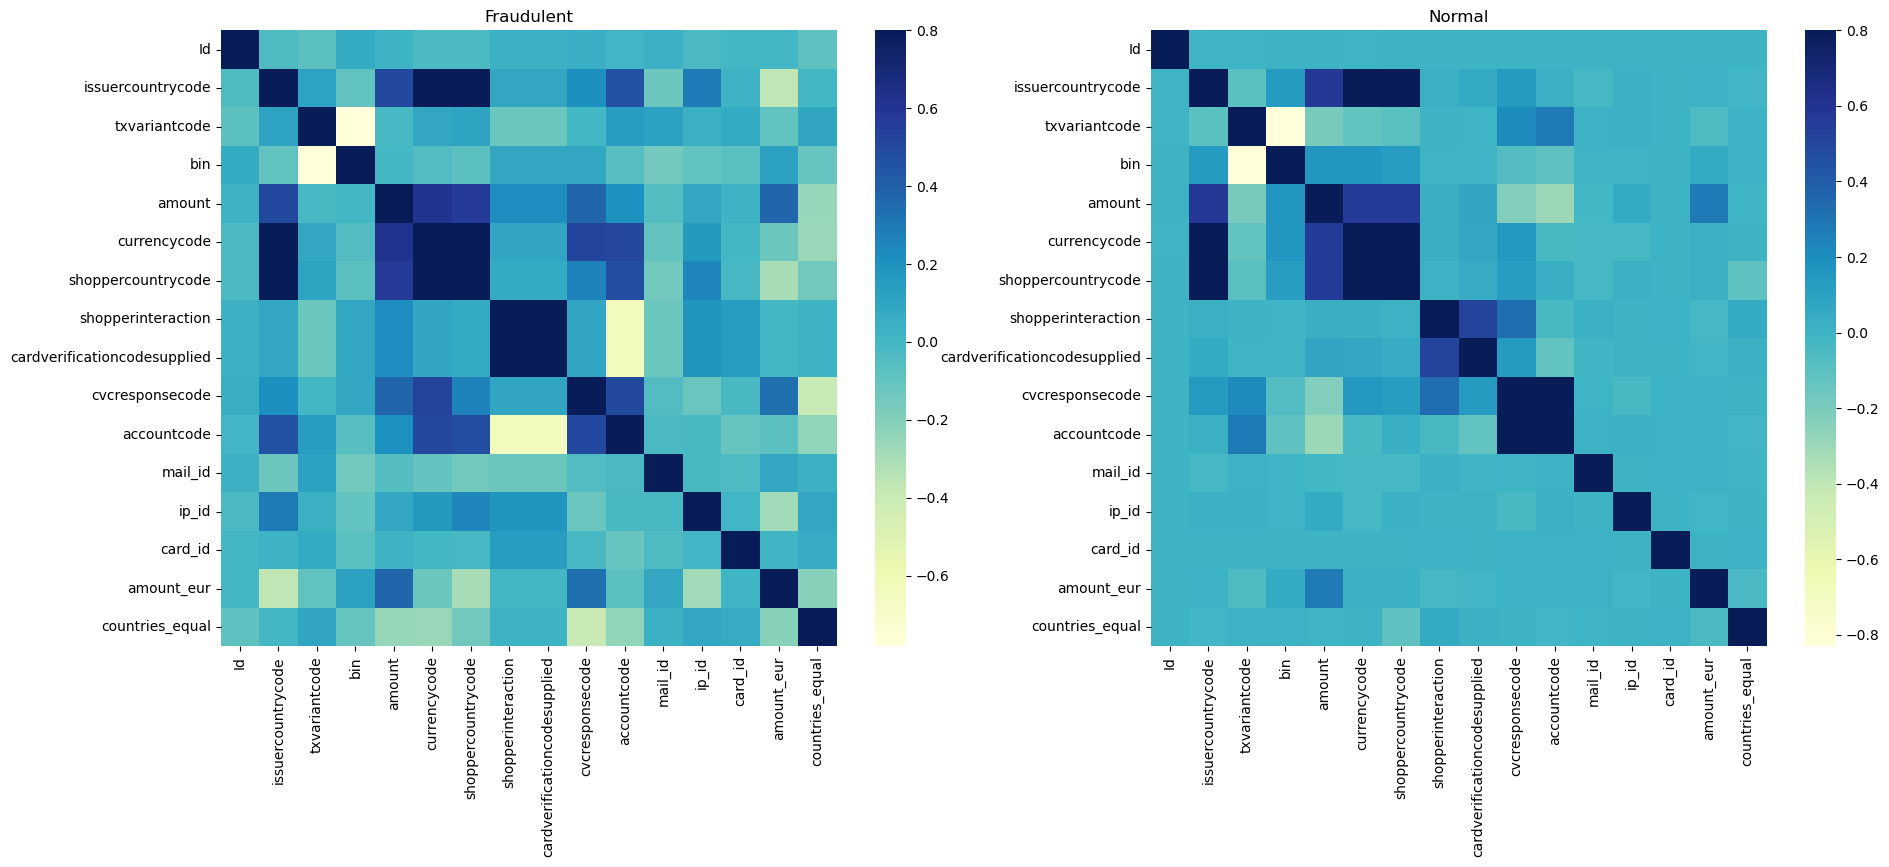

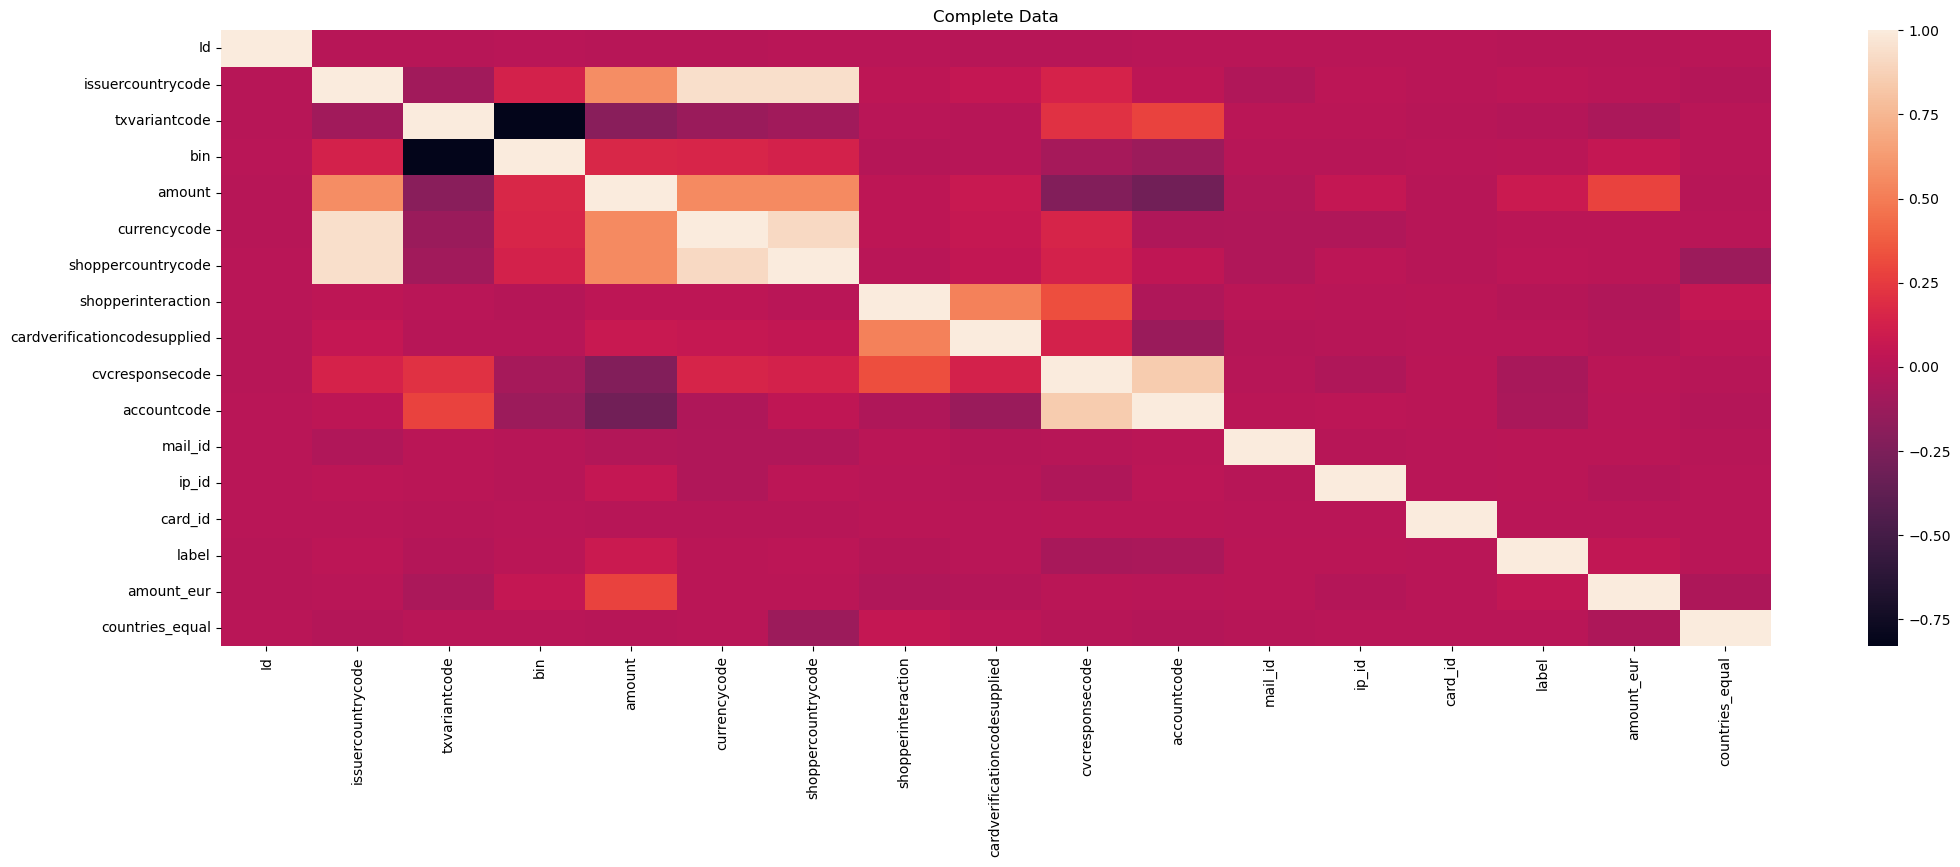

In [82]:
# Plot 1: Heatmaps for fraudulent transactions, normal transactions and complete data

#correlation matrices
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df1.query('label==1').drop(['label', 'accountcode_cc'], axis=1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraudulent')

sns.heatmap(df1.query('label==0').drop(['label', 'accountcode_cc'], axis=1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu')
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1,figsize =(25, 8))
sns.heatmap(df1.drop(['accountcode_cc'], axis=1).corr())
ax1.set_title('Complete Data')
plt.show()

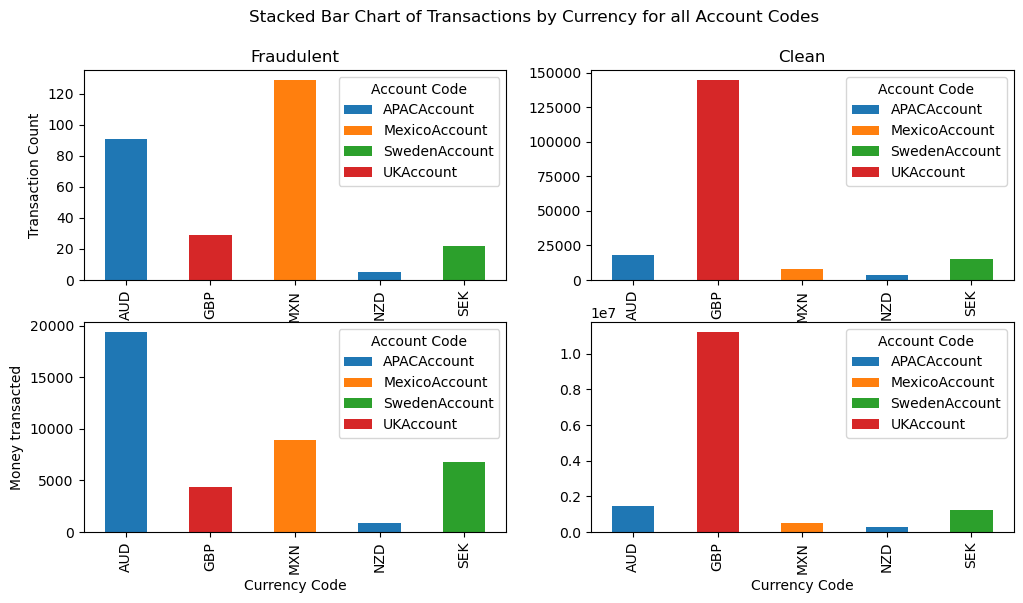

In [83]:
# Create a contingency table
table_all = pd.crosstab(df['currencycode'], df['accountcode'])
table_fraudulent = pd.crosstab(fraudulent_df['currencycode'], fraudulent_df['accountcode'])
table_normal = pd.crosstab(normal_df['currencycode'], normal_df['accountcode'])
table_fraudulent_amount = pd.crosstab(fraudulent_df['currencycode'], fraudulent_df['accountcode'], values=df['amount_eur'], aggfunc='sum')
table_normal_amount = pd.crosstab(normal_df['currencycode'], normal_df['accountcode'], values=df['amount_eur'], aggfunc='sum')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig.suptitle('Stacked Bar Chart of Transactions by Currency for all Account Codes')

# Plot a stacked bar chart
table_fraudulent.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Fraudulent')
ax1.set_xlabel('Currency Code')
ax1.set_ylabel('Transaction Count')
ax1.legend(title='Account Code')


table_normal.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Clean')
ax2.set_xlabel('Currency Code')
# ax2.set_ylabel('Transaction Count')
ax2.legend(title='Account Code')

table_fraudulent_amount.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_xlabel('Currency Code')
ax3.set_ylabel('Money transacted')
ax3.legend(title='Account Code')


table_normal_amount.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_xlabel('Currency Code')
ax4.legend(title='Account Code')

plt.show()

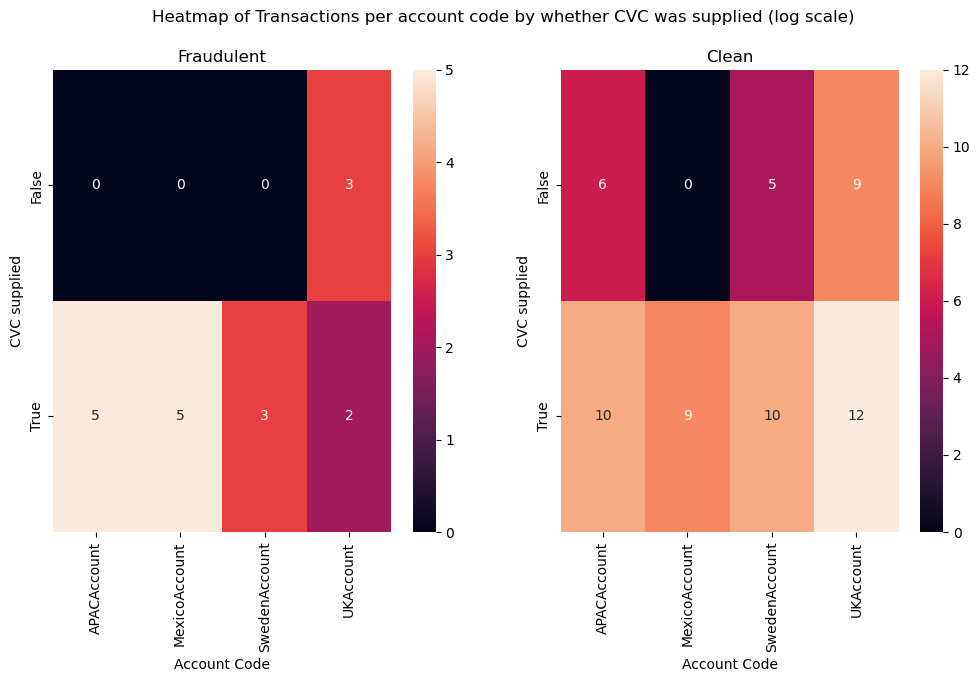

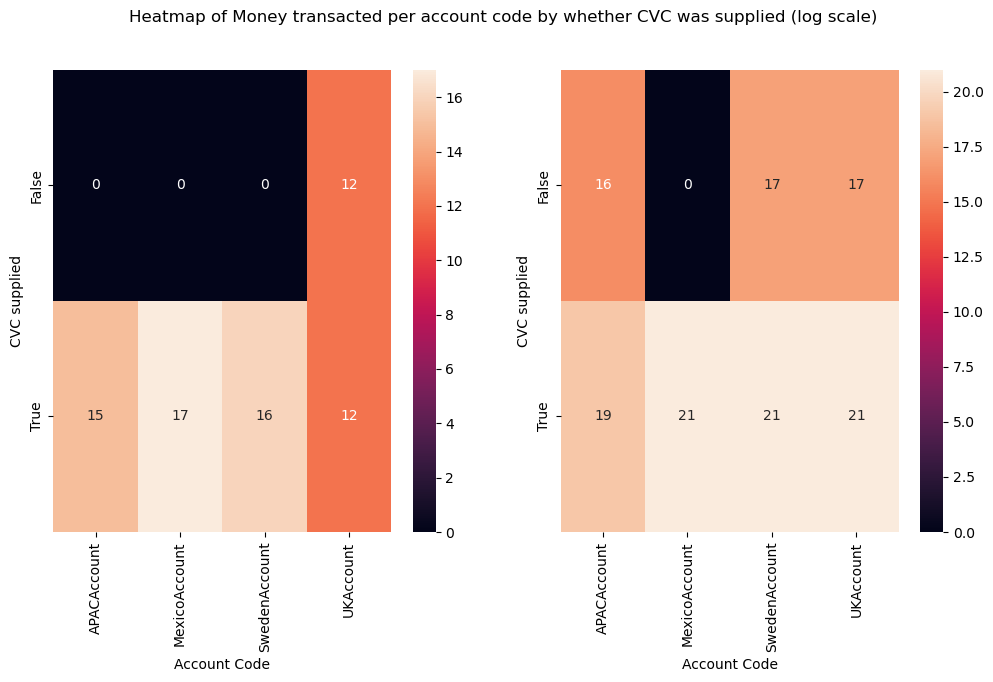

In [77]:
table_all = pd.crosstab(df['cardverificationcodesupplied'], df['accountcode'])
table_fraudulent = pd.crosstab(fraudulent_df['cardverificationcodesupplied'], fraudulent_df['accountcode']).map(lambda x: np.log(x + 1)).map(round)
table_normal = pd.crosstab(normal_df['cardverificationcodesupplied'], normal_df['accountcode']).map(lambda x: np.log(x + 1)).map(round)
table_fraudulent_amount = pd.crosstab(fraudulent_df['cardverificationcodesupplied'], fraudulent_df['accountcode'], values=df['amount'], aggfunc='sum').fillna(1).map(np.log).map(round)
table_normal_amount = pd.crosstab(normal_df['cardverificationcodesupplied'], normal_df['accountcode'], values=df['amount'], aggfunc='sum').fillna(1).map(np.log).map(round)

# sns.heatmap(table_all, annot=True, fmt='d')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig.suptitle('Heatmap of Transactions per account code by whether CVC was supplied (log scale)')

# Plot a stacked bar chart
sns.heatmap(table_fraudulent, annot=True, fmt='d', ax=ax1)
ax1.set_title('Fraudulent')
ax1.set_xlabel('Account Code')
ax1.set_ylabel('CVC supplied')

sns.heatmap(table_normal, annot=True, fmt='d', ax=ax2)
ax2.set_xlabel('Account Code')
ax2.set_ylabel('CVC supplied')
ax2.set_title('Clean')



fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Create a figure and a 1x2 subplot grid
fig2.suptitle('Heatmap of Money transacted per account code by whether CVC was supplied (log scale)')


sns.heatmap(table_fraudulent_amount, annot=True, fmt='g', ax=ax3)
ax3.set_xlabel('Account Code')
ax3.set_ylabel('CVC supplied')


sns.heatmap(table_normal_amount, annot=True, fmt='g', ax=ax4)
ax4.set_xlabel('Account Code')
ax4.set_ylabel('CVC supplied')

plt.show()

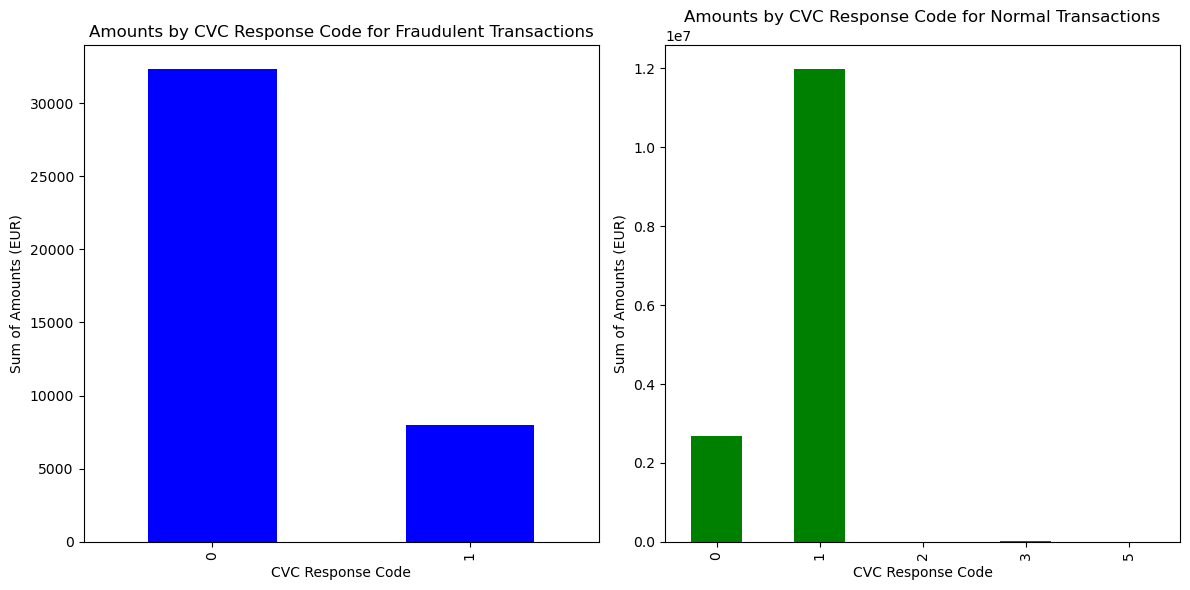

In [89]:
### Correlation between amount of euros transacted and the cvc response code
sum_fraudulent = fraudulent_df.groupby('cvcresponsecode')['amount_eur'].sum()
sum_normal = normal_df.groupby('cvcresponsecode')['amount_eur'].sum()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the bar chart for the first DataFrame
sum_fraudulent.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Amounts by CVC Response Code for Fraudulent Transactions')
ax[0].set_xlabel('CVC Response Code')
ax[0].set_ylabel('Sum of Amounts (EUR)')

# Plot the bar chart for the second DataFrame
sum_normal.plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('Amounts by CVC Response Code for Normal Transactions')
ax[1].set_xlabel('CVC Response Code')
ax[1].set_ylabel('Sum of Amounts (EUR)')

plt.tight_layout()
plt.show()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

## Visualizations

### Plot 1: Stacked bar chart of transactions by currency for all account codes
In this plot we show how many transactions as well as the total circulation of money from each currency to each account code. Firstly, it seems that all accounts deal strictly in local currency. We compare the transactions for fraudulent and normal cases, and see little difference when looking at transactions and total circulation, except for the case of fraudulent mexican transactions. Fraud is more common in mexican and australian accounts compared to normal transactions being dominated by the Brits.

### Plot 2: Heatmap of transactions and monetary circulation per account code by whether CVC was supplied (log scale)
This plot shows us that fraudulent transactions are less often CVC verified.

### Plot 3: Bar chart of CVC response code types by amount of money circulated
This plot shows us that fraudulent transactions more often have a code 0 (3x more than code 1), but for normal transactions it is 4x more common to have code 1 over 0.

## 2. Imbalance task – 1 A4 – Individual

### 2a. Print ROC curves

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

### 2c. Is using SMOTE a good idea? Why (not)?

## 3. Privacy task – 1 A4 – Individual

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## 4. Classification task – 2 A4

### 4a. Print relevant plots and metrics with clear headings.

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

## 5. Bonus task – 1 A4

### 5a. Provide code and report below